In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nn_tools import *
from itertools import product as prod

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler as rand_sampler
#from torch.utils.data import WeightedRandomSampler as rand_sampler
#from torch.utils.data import RandomSampler as rand_sampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device in use: {device}")

seed = 69420

torch.manual_seed(seed)

Training device in use: cpu


# Classification task

In [2]:
from torchvision import datasets

In [26]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomInvert(p=0.5),
        ]) 

train_dataset = datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)
test_dataset  = datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

n_train = int(len(train_dataset)/4)
n_test = int(len(test_dataset))

split_idx = int(0.75*n_train)
train_samples = rand_sampler(list(range(10)))
val_samples = rand_sampler(list(range(n_train))[split_idx:])

train_dataloader = DataLoader(train_dataset, sampler = train_samples, batch_size = 120, num_workers = 0)
val_dataloader = DataLoader(train_dataset, sampler = val_samples, batch_size = n_train - split_idx, num_workers = 0)

test_dataloader = DataLoader(test_dataset, batch_size = None, shuffle = True, num_workers = 0)

In [4]:
for batchaz in train_dataloader:
    ay = batchaz[0]
    ayay = batchaz[1]
    break

In [5]:
val_dataloader.dataset.data[0].shape

torch.Size([28, 28])

SAMPLE AT INDEX 125
LABEL: 2


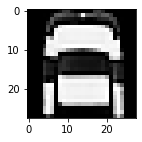

In [6]:
sample_index = 125
image = train_dataset[sample_index][0].squeeze()
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(2,2))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

img_shape = tuple(image.shape)
no_labels = len(np.unique(train_dataset.targets))

In [20]:
class CNN2D(data_API):
    
    def __init__(self, device, in_side, conv1_filters, k_size1, conv2_filters, k_size2, Nd1, Nd2, N_labels):
        """
        device - device used for computing
        in_side - side length of the square images to classify
        conv1_filters - no of filters in the first convolutional layer
        k_size1 - kernel size of each filter in conv1
        conv2_filters - no of filters in the second convolutional layer
        k_size2 - kernel size of each filter in conv2
        Nh1 - Neurons in the 2nd dense layer (first layer 
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__(device)
        super().train_model

        self.conv_shape = self.no_params_conv(
            self.no_params_conv(
                self.no_params_conv(
                    self.no_params_conv(in_side, k_size1, 0, 1),
                    2, 0, 1),
                k_size2, 0, 1),
            2, 0, 1)
        self.dropout = nn.Dropout(p = 0.4)


        self.model = nn.Sequential(
            nn.Conv2d(1, conv1_filters, k_size1),
            nn.ReLU(),
            nn.Conv2d(conv1_filters, conv2_filters, k_size2),
            nn.ReLU(),
            nn.MaxPool2d(2, stride = 1),
            nn.Flatten(),
            nn.Linear(in_features=conv2_filters*self.conv_shape**2, out_features=Nd1),
            nn.ReLU(),
            nn.Linear(in_features=Nd1, out_features=Nd2),
            nn.ReLU(),
            nn.Linear(in_features=Nd2, out_features=N_labels)
        )


        # self.conv1 = nn.Conv2d(1, conv1_filters, k_size1) # 28 to 24(* conv1_size)
        # self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, k_size2) # 24 to 12, and 12 to 8(*conv2_size)
        # self.conv_shape = self.no_params_conv(
        #     self.no_params_conv(
        #         self.no_params_conv(
        #             self.no_params_conv(in_side, k_size1, 0, 1),
        #             2, 0, 1),
        #         k_size2, 0, 1),
        #     2, 0, 1)
        # self.fc1 = nn.Linear(in_features=conv2_filters*self.conv_shape**2, out_features=Nd1)
        # self.fc2 = nn.Linear(in_features=Nd1, out_features=Nd2)
        # self.out = nn.Linear(in_features=Nd2, out_features=N_labels)


        print("Network initialized")
        
    def forward(self, x, additional_out=False):
    #    x = F.max_pool2d(F.relu(self.conv1(x)), 2, stride = 1)
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2, stride = 1)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
# #        x = self.dropout(x)
#         x = F.relu(self.fc2(x))
        # x = self.model(x)
        return self.model(x)

    def no_params_conv(self, in_size, kernel, padding, stride):
        """
        Finds no of parameters per channel after every convolution/pooling
        """
        return int((in_size - kernel + 2*padding)/stride + 1)


In [21]:
fashion_classifier = CNN2D(device, 28, 4, 3, 5, 5, 18, 14, no_labels)

fashion_classifier.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(fashion_classifier.parameters(), lr = 0.001)

num_epochs = 40

Network initialized


In [22]:
fashion_classifier.train_model(train_dataloader, num_epochs, loss_fn, optimizer, val_dataloader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (120x2205 and 2000x18)

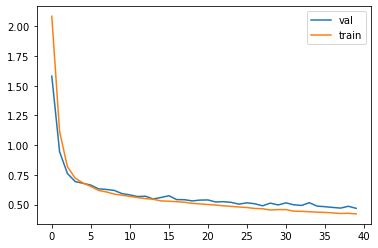

In [11]:
plt.plot(range(num_epochs), fashion_classifier.val_loss_hist, label = 'val')
plt.plot(range(num_epochs), fashion_classifier.train_loss_hist, label = 'train')
plt.legend()

In [50]:
t_range = range(10)

for batch in train_dataloader:
    for sample in batch:
        print(sample)
        break
    

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0353, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0118, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..

In [52]:
train_dataloader.__dict__

{'dataset': Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: classifier_data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                RandomInvert(p=0.5)
            ),
 'num_workers': 0,
 'prefetch_factor': 2,
 'pin_memory': False,
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 120,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.SubsetRandomSampler at 0x7f46104dff10>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f461054e070>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

For ease, I'll normalize the pixel values of the data from (0,255) to (0,1)